In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sp
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Logistische Regression - Backhaus
## Problemstellung
### Grundgedanke der logistischen Regression

Oftmals stellt sich die Frage, mit welcher **Wahrscheinlichkeit** bestimmte Ereignisse eintreten und welche **Einflussgrößen** diese Wahrscheinlichkeit bestimmen. Im einfachsten Fall werden **Komplementärereignisse** (0/1-Ereignisse) betrachtet, deren Eintrittswahrscheinlichkeiten sich in Summe zu 1 ergänzen. 
Beispiele dafür sind:
- Kauf/Nichtkauf
- Corona positiv/negativ
- Wechsel/Verbleib (Churn)

Werden die Ereignisse als **binäre** abhängige Variable $Y$ betrachtet, so gilt für die Eintrittswahrscheinlichkeiten: 
\begin{eqnarray}
P(y=0) + P(y=1) = 1\\
P(y=0) = 1 - P(y=1)
\end{eqnarray}

Die **logistische Regression** versucht über einen *Regressionsansatz* zu bestimmen, mit welcher *Wahrscheinlichkeit* ein Ereignis (z.B. Kauf einer bestimmten Margarine) in Abhängigkeit von den Einflussgrößen (z.B. Einkommen der Kunden) zu erwarten ist. at die abhängige Variable $Y$ mehr als zwei Ausprägungen, spricht man von einer **multinomialen logistischen Regression**.

Die Ähnlichkeit zur *Regressionsanalyse* besteht darin, dass die **Gewichte**, mit denen die betrachteten Einflussgrößen als unabhängige Variable die *Wahrscheinlichkeit* dafür beeinflussen, dass das Ereignis zu einer bestimmten Gruppe (etwa der Käufer) gehört. Der zentrale **Unterschied** zur Regressionsanalyse besteht darin, dass die abhängige Variable $Y$ **kein metrisches Skalenniveau** aufweist, sondern eine **kategoriale Variable** mit nominalem Skalenniveau darstellt.

Die logistische Regression versucht also nicht direkt das Ergebnis zu schätzen (wie die lineare Regression), sondern zielt auf die *Ableitung einer Eintrifftswahrscheinlichkeit* für das beobachtete Ereignis ab. Die Modellierung dieser Wahrscheinlichkeit erfolgt über die *logistische Funktion*, die auch als **Linking Function** bezeichnet wird. 

Die logistische Regression kann mit *unterschiedlichen Skalenniveaus* arbeiten. Als *unabhängige Variable* können auch Kategoriale Variable verwendet werden. Diese werden Dummy-Codiert und für jede Dummy-Variable wird ein eigener Koeffizient geschätzt. Für metrische unabhängige Variable (welche historisch auch *Kovariaten* genannt werden) wird nur ein Koeffizient geschätzt.

### Formulierung des logistischen Regressionsansatzes

Wir betrachten folgendes Beispiel: Wir wollen wissen, ob der Kauf einer neuen Premium-Buttersorte von der Einkommenshöhe der Kunden abhängt. Dafür wird für 12 ausgewählte Kunden das monatliche Nettoeinkommen erhoben ($x$) und das Ereignis (gekauft als $y=1$, nicht gekauft als $y=0$) registriert. Das Ergebnis sind 7 Käufer und 5 Nichtkäufer:

In [2]:
df = pd.DataFrame({'Ereignis': [1,1,1,1,1,1,1,0,0,0,0,0], 'Einkommen': [4000, 4200, 6000, 5200, 5500, 5100, 4800, 2700, 1800, 3200, 2500, 2600]})
df

,Ereignis,Einkommen
0,1,4000
1,1,4200
2,1,6000
3,1,5200
4,1,5500
5,1,5100
6,1,4800
7,0,2700
8,0,1800
9,0,3200


Wir führen nun eine lineare Regression auf diesen Daten aus:

In [3]:
linreg = smf.ols('Ereignis ~ Einkommen', data=df).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:               Ereignis   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     42.55
Date:                Thu, 11 Nov 2021   Prob (F-statistic):           6.70e-05
Time:                        13:05:50   Log-Likelihood:                 1.4142
No. Observations:                  12   AIC:                             1.172
Df Residuals:                      10   BIC:                             2.141
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7486      0.215     -3.478      0.0

C:\Users\apigl\.virtualenvs\bdsm-Grc_FbtC\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Die Regressionsgerade hätte also folgende Form:
\begin{equation}
\text{Kauf} = -0.7486 + 0.0003 \cdot \text{Einkommen}
\end{equation}

In der folgenden Abbildung vergleichen wir das Ergebnis der linearen Regression mit den Ausgangswerten. Dazu fügen wir die Vorhersagen für $y$ dem Dataframe als Spalte *Probability* hinzu:

In [4]:
df['Probability'] = pd.Series(linreg.params[0] + linreg.params[1]*df.Einkommen)
df

,Ereignis,Einkommen,Probability
0,1,4000,0.594526
1,1,4200,0.661680
2,1,6000,1.266073
3,1,5200,0.997454
4,1,5500,1.098186
5,1,5100,0.963877
6,1,4800,0.863144
7,0,2700,0.158020
8,0,1800,-0.144176
9,0,3200,0.325907


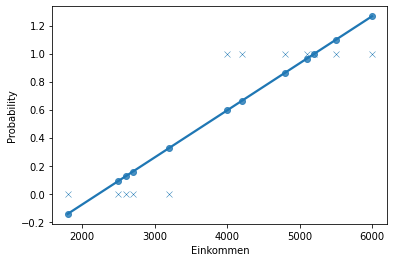

In [5]:
sns.regplot(x='Einkommen', y='Probability', data=df);
sns.scatterplot(x='Einkommen', y='Ereignis', data=df, marker="x");

An dieser Abbildung wird deutlich, warum eine lineare Regression für eine derartige Fragestellung unbrauchbar ist: Die Wahrscheinlichkeiten können negative Werte annehmen, nämlich dann, wenn ein Einkommen von (0.7486/0.0003) = 22495.33 nicht erreicht wird. Ebenso können Werte größer 1 herauskommen, nämlich für ((1+0,7486)/0.0003) = 5828.67 annehmen, was natürlich für Wahrscheinlichkeiten nicht sein darf.

Durch die 0/1-Kodierung lässt sich schnell der Mittelwert der Käufer angeben. Sieben von 12 haben gekauft, also ist der Mittelwert der Daten 7/12 = 0.5833 oder anders gesagt, 58.33% der Kunden sind Käufer.

In [6]:
print(round(100*sum(df['Ereignis'])/len(df),2), "%")

58.33 %


**Wichtig:** Die logistische Regression versucht also **nicht**, Schätzungen für die **Beobachtungen** der binären abhängigen Variablen vorzunehmen (also die Werte 0 und 1 vorherzusagen), sondern die **Eintrittswahrscheinlichkeiten** dieser Beobachtungswerte abzuleiten! 

Dabei wird die Ausprägung $y=1$ allgemein als "Ereignis $Y$ tritt ein" und $y=0$ als "Ereignis tritt nicht ein" interpretiert. Um nun die Wahrscheinlichkeiten für das Eintreten von $y=1$ (bezeichnet als $P(y=1)$) bestimmen zu können, wird unterstellt, dass eine *nicht empirisch beobachtete* latente Variable "$Z$" existiert, welche die binäre Ausprägung der abhängigen Variablen $Y$ in Abhängigkeit der unabhängigen Variablen $X_j$ erzeugen kann.

Diesen Zusammenhang können wir formal für einen Beobachtungsfall $k$ wie folgt schreiben:

$$y_k = \begin{cases}
1 \text{ falls } z_k > 0,\\
0 \text{ falls } z_k \leq 0
\end{cases}
$$

mit

$$z_k = \beta_0 + \sum_{j=1}^J \beta_j \cdot x_{jk} + u_k.$$

wobei $\beta_i$ die zu schätzenden Parameter sind und $u_k$ einen Störterm darstellt, der oftmals Null ist.

**Wichtig:** Durch die latente Variable $Z$ wird die Verbindung zwischen der binären abhängigen Variablen $Y$ und den beobachteten unabhängigen Variablen $X_j$ hergestellt.

Dabei kann die Variable $Z$ als *aggregierte Einflussstärke* der verschiedenen unabhängigen Variablen interpretiert werden, die das Ereignis herbeiführen. Dabei wird unterstellt, dass die verschiedenen Einflussgrößen $X_j$ durch eine *Linearkombination* die latente Variable $Z$ erzeugen.

**Wahrscheinlichkeitsfunktion**

Damit haben wir aber noch keine Wahrscheinlichkeitsaussage im eigentlichen Sinnm denn dazu brauchen wir eine *Wahrscheinlichkeitsfunktion*, die dann je nach Maßgabe der aggregierten Einflussstärke $Z$ das Ergebnis $y = 0$ oder $y = 1$ erzeugt. Zu diesem Zweck nutzt die logistische Regression die sogenannte *Logistische Funktion*:

$$p(z) = \frac{e^z}{1 + e^z} = \frac{1}{1 + e^{-z}}$$

**Logistische Regressionsgleichung**

Der logistische Regressionsansatz berechnet nun die Wahrscheinlichkeit für das Eintreten des Ereignisses $y=1$ unter Verwendung der *logistischen Funktion*. Dabei spiegeln der Parameter $\beta_0$ und die Regressionskoeffizienten $\beta_j$ (diese Werden häufig auch *Logit-Koeffizienten* genannt) die **Einflussstärke** der jeweils betrachteten unabhängigen Variablen $X_j$ auf die Höhe der Eintrittswahrscheinlichkeiten $P(y=1)$ wieder.

**Wichtig:** Die logistische Funktion stellt somit eine Wahrscheinlichkeitsbeziehung zwischen dem Ereignis $y=1$ und den unabhängigen Variablen $X_j$ her, weshalb sie auch als *Linking-Function* bezeichnet wird.

Die *logistische Regressionsgleichung* lautet dann:

$$p_k(y=1) = \frac{1}{1 + e^{-z_k}}$$

mit

$$z_k = \beta_0 + \sum_{j=1}^J \beta_j \cdot x_{jk} + u_k.$$

wobei die z-Werte auch als **Logits** bezeichnet werden.

Die so erzeugte Wahrscheinlichkeitsverteilung für das Ereignis $y=1$ weist einen s-förmigen Verlauf auf und hat die Eigenschaft, dass selbst für unendlich kleine oder auch große Werte von $Z$ sich die Wahrscheinlichkeit immer innerhalb des Intervalls [0,1] bewegt. Die logistische Funktion ist weiters immer *symmetrisch* um den Wendepunkt $P(y=1) = 0.5$.

Die folgende Abbildung zeigt den Verlauf der logistischen Funktion im Intervall [-6, 6]:

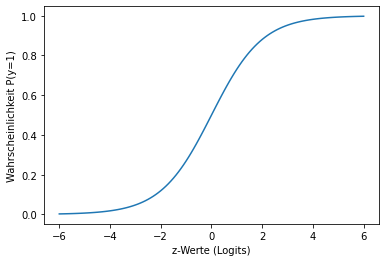

In [7]:
x = np.array([i/10 for i in range(-60,61)])
y = 1/(1+np.exp(-x))
plt.plot(x, y);
plt.xlabel('z-Werte (Logits)');
plt.ylabel('Wahrscheinlichkeit P(y=1)');

**Wichtig:** Die logistische Regressionsfunktion unterstellt damit einen **nicht-linearen Zusammenhang** zwischen der Eintrittswahrscheinlichkeit der binären, abhängigen Variablen $P(y=1)$ und den unabhängigen Variablen als **Modelprämisse**. Hingegen wird aber das Zustandekommen der aggregierten Einflussstärke $Z$ im Exponenten der Linking-Funktion als **linear** unterstellt.

## Vorgehensweise
### Modellformulierung

Bei einer Regression werden Je-Desto Hypothesen aufgestellt. Beachte folgenden **wesentlichen Unterschied** zwischen linearer und logistischer Regression:

- *lineare Regression:* Zusammenhang zwischen den **unabhängigen** Variablen und der **abhängigen** Variablen
- *logistische Regression:* Zusammenhang zwischen den **unabhängigen** Variablen und der **Eintrittswahrscheinlichkeit** für das Ereignis $y=1$.

In unserem Beispiel bedeutet das:

- lineare Regression: Je streichfähiger und haltbarer die Margarine, desto *mehr* wird davon gakauft
- logistische Regression: Je streichfähiger und haltbarer die Margarine, desto *wahrscheinlicher* ist es, dass es zu einem Kauf kommt

Die in den Hypothesen der logistischen Regression angenommenen Wirkungsbeziehungen abeh **keinen linearen** Charakter.

In diesem Beispiel soll untersucht werden, mit welcher Wahrscheinlichkeit der Kauf von Margarine $(y=1)$ zu erwarten ist und in welchem Ausmaß die Kaufwahrscheinlichkeit durch die Merkmale "Streichfähigkeit" und "Haltbarkeit" beeinflusst wird. Dazu wurden die beiden Merkmale von 24 Befragten Personen auf einer Ratingskala zwischen 1 = geringe Kaufbedeutung und 7 = hohe Kaufbedeutung bewertet. In den Daten sind 12 Käufer und 12 Nichtkäufer. Die Beurteilungswerte werden als metrisch skaliert interpretiert.

In [8]:
df = pd.DataFrame({'Kauf': [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0], 'Streichfaehigkeit': [2,3,6,4,3,4,3,2,5,3,3,4,5,4,7,3,4,5,4,5,6,5,6,6], 'Haltbarkeit': [3,4,5,4,2,7,5,4,6,6,3,5,4,3,5,3,4,2,2,5,7,3,4,6]})
y = df['Kauf']
X = df[['Streichfaehigkeit','Haltbarkeit']]
df.sample(5)

,Kauf,Streichfaehigkeit,Haltbarkeit
17,0,5,2
20,0,6,7
18,0,4,2
7,1,2,4
2,1,6,5


### Schätzung der logistischen  Regressionsfunktion

Die Modellparameter der logistischen Regression werden mit der *Maximum Likelihood-Methode* geschätzt. Die Parameter $b_j$ werden dabei so geschätzt, dass die Wahrscheinlichkeit (Likelihood), die beobachteten Daten zu erhalten, maximiert wird. 

Im Rahmen einer empirischen Erhebung ergibt sich für jede Person entweder die Beobachtung $y=1$ oder $y=0$. Das bedeutet, dass die Parameterschätzung für die jeweils betrachtete Person entweder die Wahrscheinlichkeit $P(y=1)$ oder $P(y=0)$ ergeben sollte. Das ist genau dann der Fall, wenn für jeden Beobachtungsfall $k$ folgende Beziehung betrachtet wird:

$$p_k(y) = 
\begin{cases}
\Big(\frac{1}{1+e^{-z_k}}\Big) \text{ für } y_k=1\\
\Big(1-\frac{1}{1+e^{-z_k}}\Big) \text{ für } y_k=0\\
\end{cases}
$$

Das läßt sich auch in einer Gleichung ausdrücken:

$$p_k(y) = \underbrace{ \Big( \frac{1}{1 + e^{-z_k}} \Big)^{y_k} }_{\text{Faktor A}} \cdot \underbrace{\Big( 1 - \frac{1}{1 + e^{-z_k}} \Big)^{y_k}}_{\text{Faktor B}}
$$

Die Parameter $b_j$ des Regressionsmodells sind nun so zu schätzen, dass die Wahrscheinlichkeit (Likelihood) maximiert wird, dass die empirischen Beobachtungswerte ($y = 1$ bzw. $y = 0$) für möglichst alle erhobenen Fälle zu erhalten. Dabei ist zu beachten, dass die Zuweisung eines Falls zu einer bestimmten Kategorie einer **Zuordnungsvorschrift** bedarf. In der Regel wird hier ein Wahrscheinlichkeitswert von 0.5 verwebdet, d.h. für

- $p_k > 0.5$ erfolgt eine Zuordnung zum Ereignis $y = 1$
- $p_k < 0.5$ erfolgt eine Zuordnung zum Ereignis $y = 0$.

Um die obige Wahrscheinlichkeit für alle Beobachtungsfälle **gleichzeitig** zu maximieren, ist der *Wahrscheinlichkeitssatz für unabhängige Ereignisse* anzuwenden. Er besagt, dass sich für unabhängige Ereignisse (hier die Beobachtungswerte der abhängigen Variable) die Wahrscheinlichkeitendes **gleichzeitigen** Eintretens der Ereignisse durch Multiplikation der Einzelereignisse ergibt ($P(A\cap B) = P(A)\cdot P(B)$). Damit ist als Zielfunktion das Produkt der Wahrscheinlichkeiten über alle Befragten $k = 1,\dots,K$ zu maximieren, was durch die sogenannte **Likelihood-Funktion L** zum Ausdruck gebracht wird:

$$L = \prod_{k=1}^{K} \Big( \frac{1}{1 + e^{-z_k}} \Big)^{y_k} \cdot \Big( 1 - \frac{1}{1 + e^{-z_k}} \Big)^{y_k} \rightarrow \max$$

Eine Vereinfachung des Maximierungsproblems wird erreicht, in dem man den natürlichen Logarithmus der Likelihood-Funktion betrachetet. Dadurch erhält man die **Log-Likelihood Funktion LL**:
$$
LL = \sum_{k=1}^{K} y_k \cdot \ln \Big( \frac{1}{1 + e^{-z_k}}\Big)  + (1-y_k)\cdot \Big( 1 - \frac{1}{1 + e^{-z_k}} \Big)

$$
Parameterschätzungen, die $L$ maximieren, maximieren gleichzeitig auch $LL$. Die *(Log)Likelihood-Funktion* wird in der Regel mit dem *Newton-Raphson Algorithmus* maximiert. 

Für unser Margarine-Beispiel erhalten wir:

In [9]:
model = sm.Logit(y.values, statsmodels.tools.tools.add_constant(X.values))
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.387303
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   24
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                  0.4412
Time:                        13:05:50   Log-Likelihood:                -9.2953
converged:                       True   LL-Null:                       -16.636
Covariance Type:            nonrobust   LLR p-value:                 0.0006489
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5277      2.338      1.509      0.131      -1.055       8.111
x1            -1.9427      0.

Die Regressionsgleichung ist somit:

$z_k = 3.5277 - 1.9427 \cdot \text{Streichf} + 1.1194 \cdot \text{Haltb}$

Mit Hilfe der Regressionsschätzung lassen sich mit den Erhebungsdaten für alle 24 Befragten im ersten Schritt die aggregierten Einflussgrößen (z-Werte bzw. Logits) berechnen. Mit Hilfe der Logits können dann unter Verwendung der logistischen Funktion die personenbezogenen Wahrscheinlichkeiten für das Ereignis "Margarinekauf" ($y=1$) bestimmt werden:

In [10]:
result.params

array([ 3.52770707, -1.94273433,  1.1194205 ])

In [11]:
beta_0 = result.params[0]
beta_1 = result.params[1]
beta_2 = result.params[2]

In [12]:
# z-Werte bestimmen
z = beta_0 + beta_1*X.iloc[:,0] + beta_2 * X.iloc[:,1]
z

0     3.000500
1     2.177186
2    -2.531596
3     0.234452
4    -0.061655
5     3.592713
6     3.296607
7     4.119920
8     0.530558
9     4.416027
10    1.057766
11    1.353872
12   -1.708283
13   -0.884969
14   -4.474331
15    1.057766
16    0.234452
17   -3.947124
18   -2.004389
19   -0.588862
20   -0.292755
21   -2.827703
22   -3.651017
23   -1.412176
dtype: float64

In [13]:
# Anwendung der logistischen Funktion
prob = 1/(1+np.exp(-z))

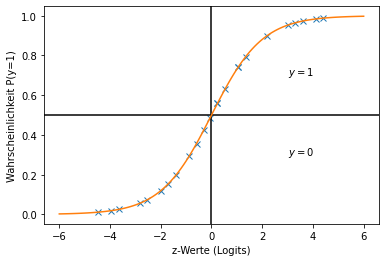

In [14]:
plt.plot(z, prob, 'x');
x = np.array([i/10 for i in range(-60,61)])
sigmoid = 1/(1+np.exp(-x))
plt.axhline(y = 0.5, color = 'black', linestyle = '-') 
plt.axvline(x = 0, color = 'black', linestyle = '-') 
plt.plot(x, sigmoid);
plt.text(3, 0.7, "$y=1$");
plt.text(3, 0.3, "$y=0$");
plt.xlabel('z-Werte (Logits)');
plt.ylabel('Wahrscheinlichkeit P(y=1)');

### Interpretation der Regressionskoeffizienten

Die im vorangegangenen Schritt erbrachte Regressionsschätzung bereitet bei der inhaltlichen Interpretation einige Schwierigkeiten, da **kein linearer** Zusammenhang zwischen den unabhängigen Variablen $X_j$ und den über die logistische Funktion bestimmten Wahrscheinlichkeiten $p_k(y=1)$ existiert.

Da die unabhängigen Variablen den Exponenten der e-Funktion bestimmen, nehmen sie zum einen nur *indirekt* (über die Wahrscheinlichkeitsberechnung) und zum anderen in *nicht-linearer* Form (durch die unterstellte logistische Funktion) Einfluss auf die Bestimmuing der Eintrittswahrscheinlichkeit für das Ereignis $y=1$.  Das hat zur Konsequenz, dass 

- weder die Regressionskoeffizienten untereinander vergleichbar sind,
- noch die Wirkung der unabhängigen Variablen über die gesamte Breite ihrer Ausprägungen konstant ist.

Damit ist auch eine (lineare) INterpretation der Schätzergebnisse z.B. in der Form "Eine Verbesserung der Streichfähigkeit um eine Einheit erhöht die Wahrscheinlichkeit des Margarinekaufs um so und so viel" - so wie bei der linearen Regression - **nicht** möglich!

Eine lineare Verknüpfung wird lediglich für die *aggregierte Einflussstärke* in Form des $z$-Wertes (Logits) unterstellt. Dadurch, dass die unabhängigen Variablen $X_j$ als *Linearkombinationen* angenommen werden, der Zusammenhang zwischen der Eintrittswahrscheinlichkeit und dem Ereignis $y=1$ aber *nicht-linear* ist, folgt unmittelbar das oben genannte **Interpretationsproblem**.

Durch die Betrachtung der logistischen Funktion als Wahrscheinlichkeitsverteilung wird ein **Sättigungseffekt** abgebildet (hier: maximale Eintrittswahrscheinlichkeit von 1), der dazu führt, dass Änderungen in den Extrembereichen der latenten Variablen $Z$ nicht mehr zu wesentlichen Änderungen der Eintrittswahrscheinlichkeit führen.

Die folgende Abbildung macht deutlich, dass der Parameter $\beta_0$ die **Lage** der logistischen Funktion in der Horizontalen beeinlusst:

- Für positive $\beta_0$ (hier 3) verschiebt sie sich nach links.
- Für negative $\beta_0$ (hier -3) findet eine Rechtsverschiebung statt.

Demgegenüber beeinflussen die Regressionskoeffizienten $\beta_j$ den **Verlauf** der logistischen Funktion in der Weise, dass 
sich die Wahrscheinlichkeitswerte für große $\beta_j$ ($\beta_j > 1$) sehr schnell den Randbereichen der logistischenb Funktion (0 und 1) annähern, während die Wahrscheinlichkeitswerte für kleine $\beta_j$ ($0 < \beta_j < 1$) in Abhängigkeit von $X$ nur sehr langsam ansteigen. 

Bei einem Regressionskoeffizienten $\beta_j = 0$ liegen die sich ergebenden Wahrscheinlichkeiten für alle Beobachtungen der Unabhängigen Variablen $X_j$ bei 0.5 (da $e^0 = 1$ und somit $1/(1 + e^0) = 0.5$)

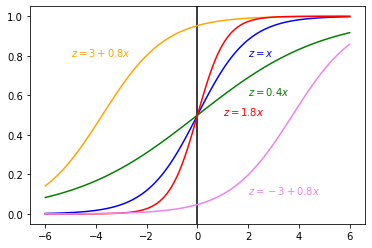

In [15]:
x = np.array([i/10 for i in range(-60,61)])
z1 = x
z2 = 3 + 0.8*x
z3 = 0.4*x
z4 = 1.8*x
z5 = -3+0.8*x
y1 = 1/(1+np.exp(-z1))
y2 = 1/(1+np.exp(-z2))
y3 = 1/(1+np.exp(-z3))
y4 = 1/(1+np.exp(-z4))
y5 = 1/(1+np.exp(-z5))
plt.axvline(x = 0, color = 'black', linestyle = '-') 
plt.plot(x, y1, color="blue");
plt.plot(x, y2, color="orange");
plt.plot(x, y3, color="green");
plt.plot(x, y4, color="red");
plt.plot(x, y5, color="violet");
plt.text(2, 0.8, "$z=x$", color="blue");
plt.text(-5, 0.8, "$z=3+0.8x$", color="orange");
plt.text(2, 0.6, "$z= 0.4x$", color="green");
plt.text(1, 0.5, "$z= 1.8x$", color="red");
plt.text(2, 0.1, "$z=-3+0.8x$", color="violet");

Während für *positive Regressionskoeffizienten* $\beta_j$ die Wahrscheinlichkeiten mit größer werdenden Beobachtungen ebenfalls - wenn auch nicht linear - ansteigen, bewirken *negative Regressionskoeffizienten* ein Absinken der Wahrscheinlichkeit $P(y=1)$ mit ansteigenden Beobachtungswerten der unabhängigen Variablen.

Die folgende Abbildung zeigt ein entsprechendes Beispiel für $z = 0.8\cdot x$ und $z = -0.8\cdot x$:

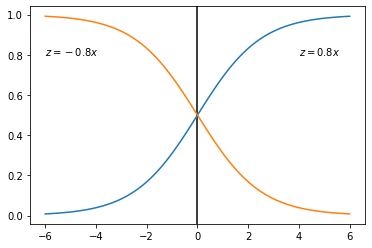

In [16]:
x = np.array([i/10 for i in range(-60,61)])
z1 = 0.8*x
z2 = -0.8*x
y1 = 1/(1+np.exp(-z1))
y2 = 1/(1+np.exp(-z2))
plt.axvline(x = 0, color = 'black', linestyle = '-') 
plt.plot(x, y1);
plt.plot(x, y2);
plt.text(-6, 0.8, "$z=-0.8x$");
plt.text(4, 0.8, "$z=0.8x$");

Insgesamt kann damit festgehalten werden, dass sich gleiche Veränderungen in den Beobachtungswerten der unabhängigen Variablen $X_j$ in verschiedenen Bereichen der logistischen Funktion *unterschiedlich* auf die Eintrittswahrscheinlichkeiten $P(y=1)$ auswirken. Das bedeutet, dass eine Änderung in der Ausprägung einer Variablen $X$ z.B. von 1 auf 2 eine andere Wahrscheinlichkeitswirkung nach sich zieht als etwa eine Erhöhung von 3 auf 4, obwohl die Veränderung von $X$ in beiden Fällen $\Delta X=1$ beträgt.

Aufgrund dieser nicht-linearen Zusammenhänge können die Schätzungen der Parameter $\beta_j$ auch **nicht** - wie bei der linearen Regression - als **globales Maß** für die Einflussstärke der $X_j$ auf die $p_k$ gewertet werden.

Entsprechend der oben aufgezeigten Zusammenhänge kann zusammenfassend festgehalten werden, dass aufgrund des logistischen Funktionsverlaufs ohne weitere Mühe nur die **Richtung des Einflusses** der unabhängigen Variablen erkennbarer ist. Für steigende $X$-Werte gilt:

- **Negative** Regressionskoeffizienten führen zu einer **kleineren Wahrscheinlichkeit** für die Ausprägung $y=1$
- **Positive** Regressionskoeffizienten führen zu einer **größeren Wahrscheinlichkeit** für das Ereignis $y=1$

Ein negatives $\beta_j$ führt ceteris paribus dazu, dass der Wert der Linearkombination $z_k = \beta_0 + \beta_1 x_{1k} + \cdots + \beta_J x_{Jk}$ bei steigenden Ausprägungen der Variablen $X_j$ kleiner wird. 

Demnach weist eine hohe Ausprägung der unabhängigen Variablen darauf hin, dass der Befragte $k$ eher der Gruppe der Nichtkäufer ($y=0$) angehört. Genau umgekehrt verhält es sich bei einem positiven $\beta_j$ Wert:

ABBILDUNG 5.11 nachbauen!!

Eine Interpretationserleichterung kann nun dadurch erreicht werden, dass *nicht* die Eintrittswahrscheinlichkeit $P(y=1)$ selbst, sondern *ihr Verhältnis zur Gegenwahrscheinlichkeit* $P(y=0)$ bzw. $1 - P(y=1)$ betrachtet wird. Dieses *Wahrscheinlichkeitsverhältnis* steht für die Chance (*Odd*), das Ereignis $y=1$ im Vergleich zum Ereignis $y=0$ zu erhalten. 

Die **Odds der logistischen Regression** sind definiert als:

$\text{Odds}(y=1) = \frac{p(y=1)}{1-p(y=1)}$

Es gilt weiters:

$p(y=1) = \frac{e^z}{1+e^z}$

$p(y=1)\cdot(1+e^z) = e^z$

$p(y=1) + p(y=1)\cdot e^z = e^z$

$p(y=1) = e^z - p(y=1)\cdot e^z$

$p(y=1) = e^z \cdot (1-p(y=1))$

$\text{Odds: } \frac{p(y=1)}{1-p(y=1)} = e^z$

Die Odds erweitern daher den Wertebereich des Ereignisses $y=1$ auf das Intervall $[0,-\infty]$. So korrespondiert beispielsweise mit $P(y=1)=0.8$ eine Chance von 4 (=0.8/0.2), dass das Ereignis $y=1$ eintritt, während das Chancenverhältnis für $P(y=1)=0.4$ nur bei 0.66 (=0.4/0.6) liegt.

Bezogen auf unser Margarinebeispiel wäre bei einer Odd von 4 die Chance für einen Margarinekauf viermal höher als für einen Nichtkauf.

Werden in einem zweiten Schritt die Odds logarithmiert, wobei üblicherweise der Logarithmus naturalis (ln) verwendet wird, so ergibt sich folgender Zusammenhang für die **Logits der logistischen Regression**:

$\ln \Big(\frac{p(y=1)}{1-p(y=1)}\Big) = z\ln(e) = z$

$\ln \Big(\frac{p(y=1)}{1-p(y=1)}\Big) = \beta_0 + \sum_{j=1}^J \beta_j \cdot x_{jk} + u_k$

Die logarithmierten Odds werden üblicherweise **Logits** bezeichnet und entsprechen der aggregierten Einflussstärke $Z$. Sie stellen eine Linearkombination der unabhängigen Variablen dar und erlauben damit eine Interpretation analog zur linearen Regressionsanalyse. Außerdem ist der Wertebereich der Logits auf das Intervall $[-\infty, \infty]$ ausgedehnt, da der Logarithmus naturalis für Werte zwischen 0 und 1 negativ wird. 

Die Überlegungen machen deutlich, dass die durch die Regressionskoeffizienten bestimmte aggregierte Einflussstärke auf die Eintrittswahrscheinlichkeit des Ereignisses $y=1$ (z-Werte), die Logits und die Odds **exakt** den gleichen Sachverhalt beschreiben.

Sie stellen lediglich **verschiedene Möglichkeiten der Ergebnisinterpretation** dar, so dass gilt:

$Z = \text{ Logit } = \ln(\text{Odds})$

Übertragen wir die obigen Überlegungen auf unser Rechenbeispiel, so ist eine Interpretation der Parameterschätzungen der logistischen Regression wie folgt möglich:

- Für die Variable "Streichfähigkeit" wurde ein Regressionskoeffizient von -1.943 ermittelt, womit diese Variable - aufgrund des negativen Vorzeichens des Koeffizienten - die Kaufwahrscheinlichkeit $P(y=1)$ für Margarine **reduziert**.
- Demgegenüber beeinflusst die Variable "Haltbarkeit" mit einem Regressionskoeffizienten von 1.119 die Margarine-Kaufwahrscheinlich **positiv**.

Neben diesen Tendenzaussagen ist eine genauere Aussage über die Höhe der Einflussstärken der beiden Variablen auf die Eintrittswahrscheinlichkeiten mit Hilfe der Odds über die sogenannte **"odds ratio"** erzielbar, die auch als **Effekt-Koeffizienten** bezeichnet werden:

- Erhöht sich eine unabhängige Variable um eine Einheit (also $x_j+1$), so vergrößert sich das Chancenverhältnis zu Gunsten des Ereignisses $y=1$ (Odds) um den Faktor $e^\beta_j$.

Die Wirkung des Effekt-Koeffizienten $e^{\beta_j}$ bei Erhöhung der Variablen $x_j$ um eine Einheit ($x_j+1$) lässt sich anhand der Odds ($e^Z$) wie folgt verdeutlichen:

$e^{\beta_0 + \beta_1 \cdot (x+1)} =  e^{\beta_0} \cdot e^{\beta_1 x}\cdot e^{\beta_1}$

$= \Big(e^{\beta_0 + \beta_1x}\Big)\cdot e^{\beta_1}$

$= e^{Z}\cdot e^{\beta_1}$

$= \text{Odds}\cdot e^{\beta_1}$

Bezogen auf unser Rechenbeispiel steigert somit die Erhöhung der Haltbarkeit um eine Einheit die Odds um den Faktor 3.062 (=e^{1.119}), während eine Erhöhung der Streichfähigkeit die Odds nur um den Faktor 0.143 (=e^{-1.943}) verringert. Die allgemeine Wirkung der odds ratio bzw. des Effekt-Koeffizienten ist in der folgenden Abbildung zu sehen, wobei deutlich wird, dass der Effekt-Koeffizient nur Werte zwischen 0 und $+\infty$ annehmen kann.

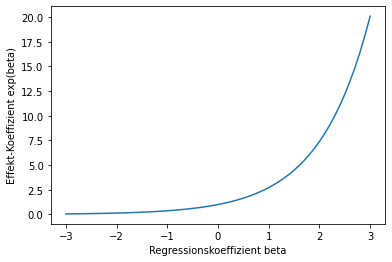

In [17]:
b = np.array([i/10 for i in range(-30,31)])
exp_b = np.exp(b)
plt.plot(b, exp_b);
plt.xlabel('Regressionskoeffizient beta');
plt.ylabel('Effekt-Koeffizient exp(beta)');

Der Zusammenhang zwischen den verschiedenen hier vorgestellten Interpretationsmöglichkeiten ist hier nochmals zusammenfassend dargestellt:

| Regressions Koeffizient $\beta$ | Effekt Koeffizient $e^{\beta}$ | Logit $z$ | Odds | P(y=1)|
| --- | --- | --- | --- | --- |
| $\beta > 0$ | $e^{\beta} > 1$ | steigt um $\beta$ | steigt um $e^{\beta} > 1$ | steigt |
| $\beta < 0$ | $e^{\beta} < 1$ | sinkt um $\beta$ | sinkt um $e^{\beta} > 1$ | fällt |

## Prüfung des Gesamtmodells

Bei der Prüfiung des Gesamtmodells stehen zwei Fragen im Vordergrund:

1. Wie gut können die Parameterschätzungen in ihrer Gesamtheit das definierte Regressionsmodell abbilden?
1. Liegen extreme Beobachtungsfälle vor, die als Ausreißer anzusehen sind und eine Eliminierung oder aber aufgrund ihres gehäuften Auftretens gegebenenfalls eine Modellveränderung erfordern?

Beiden Fragen wird im Folgenden nachgegangen. Zunächst werden ausgewählte Gütemaße behandelt, die Auskunft über den Gesamtfit des analysierten Modells geben, und anschließend wird eine Ausreißerdiagnostik durchgeführt.

### Gütemaße für den Regressionsansatz

Bei der Beurteilung der Modellgüte eines logistischen Regressionsansatzes insgesamt (**Gesamtfit**) steht die Frage im Vordergrund, wie gut die unabhängigen Variablen in ihrer **Gesamtheit** zur Trennung der Ausprägungskategorien von $Y$ beitragen. Zur Beantwortung dieser Frage kann auf verschiedene Arten von Gütekriterien zurückgegriffen werden, die sich wie folgt strukturieren lassen: 

1. Gütekriterien auf der Basis der LogLikelihood-Funktion
1. Pseudo-$R^2$-Statistiken
1. Beurteilung der Klassifikationsergebnisse

#### Gütekriterien auf Basis der LL-Funktion
##### Analyse der Devianz bzw. des -2LogLikelihood-Wertes

Der Likelihood gibt die Wahrscheinlichkeit wieder, unter den gegebenen Parameterschätzungen die empirisch erhobenen Beobachtungswerte zu erhalten. Wird an Stelle des Likelihood das -2-fache des logarithmierten Likelihood (-2LL) betrachtet, so läßt sich zeigen, dass diese Größe Approximativ einer *$\chi^2$-Verteilung* mit $(K-J-1)$ Freiheitsgraden folgt, wobei $K$ die Zahl der Beobachtungen und $J$ die Anzahl der Parameter darstellt.

Die Größe $-2LL$ wird auch als **Devianz** (Abweichung vom Idealwert) bezeichnet und kann inhaltlich mit der Fehlerquadratsumme der klassischen Regressionsanalyse verglichen werden. Sie dient weiterhin als **Gütemaß zur Überprüfung des Modellfits**.

Ein perfekter Modellfit hat 

- einen Likelihood von 1
- und daher eine Devianz von 0

Mit Hilfe der Devianz kann folgende Hypothese getestet werden: 

> $H_0$: Das Modell besitzt eine perfekte Anpassung

> $H_1$: Das Modell besitzt *keine* perfekte Anpassung

Weist die Devianz einen **geringen** Wert auf, so kann die Nullhypothese **nicht verworfen** werden und es kann auf eine **gute Anpassung** geschlossen werden. Entsprechend impliziert eine **hohe** Irrtumswahrscheinlichkeit basierend auf einem **hohen Wert** der Devianz die **Ablehnung** der Nullhypothese (hohes Signifikanzniveau) und spricht damit für eine **schlechte Anpassung** des Gesamtmodells. 

Für das hier betrachtete Rechenbeispiel berechnen wir uns zunächst die LL:

In [18]:
LL = np.sum(y*np.log(1/(1+np.exp(-z)))+(1-y)*np.log(1- 1/(1+np.exp(-z))))
LL

-9.295282622785976

Und die Devianz:

In [19]:
devianz = -2*LL
devianz

18.590565245571952

Diesen vergleichen wir nun mit dem $\chi^2$ Wert für 5% Irrtumswahrscheinlichkeit und $(K - J - 1) = (24 - 2 - 1) = 21$ Freiheitsgraden:

In [20]:
sp.chi2.ppf(1-0.05,24-2-1)

32.670573340917315

Da die Devianz kleiner ist, kann damit die Nullhypothese nicht verworfen werden, d.h. unser Modell weist in dieser Form eine sehr gute Anpassung auf.

Die Devianz ist als Gütemaß in der Literatur jedoch **umstritten**: Ihr Problem liegt in der **Nichtberücksichtigung** der Verteilung der Beobachtungen auf die Gruppen!

Dass die Häufigkeit des Auftretrens der jeweiligen Kategorien eine Rolle spielt, wird sofort klar, wenn im Extrem ein Datensatz mit 100 Beobachtungen betrachtet wird, von denen 99 einer Gruppe $y = 1$ angehören. Stellen wir uns ein Modell vor, in dem **keine** unabhängige Variable berücksichtigt wird, das als nur aus dem Absolutterm $\beta_0$ besteht. 

Schreiben wir die $LL$-Funktion mit den Wahrscheinlichkeiten der Ereignisse ($p(y=1) = 0.99$, also 

$$LL = \sum_{k=1}^K y_k \ln p(y=1) + (1-y_k) \ln(1-p(y=1)) = 99 \cdot \ln(0.99) + 1 \cdot \ln(1-0.99) = -5.620$$

und damit sind wir schon sehr nahe bei 0, dem absoluten Maximum der LL Funktion.

Liegt hingegen bei gleicher Beobachtungszahl eine Gleichverteilung der zwei Kategorien vor (50:50), dann bekommen wir einen LL-Wert von 

$$LL = 50 \cdot \ln(0.5) + 50 \cdot \ln(0.5) = -69.31$$

Es wird offensichtlich, dass der **Abstand** des LL-Wertes von Null auf **zwei Einflüsse** zurückzuführen ist:

- Zum einen wird er bestimmt von der **Trennfähigkeit** der Variablen,
- zum anderen beeinflusst ihn aber auch die **Verteilung der Beobachtungen auf die Kategorien** der abhängigen Variablen.

Für die **Devianz als Gütekriterium** hat das zur Konsequenz, dass ein Modell auf Basis eines Datensatzes mit einer sehr schiefen Verteilung zwischen den Gruppen in der Tendenz besser bewertet wird, als ein Modell mit nahezu gleich großer Gruppenstärke. Die Devianz reagiert insoweit nicht ausschließlich auf die Trennfähigkeit der betrachteten unabhängigen Variablen.

##### Likelihood-Ratio Test

Die mit der Devianz verbundenen Probleme versucht der sogenannte **Likelihood-Ratio-Test** (auch "Modell $\chi^2$-Test" genannt) zu beheben, indem er den maximierten LL-Wert nicht mit Null, sondern mit demjenigen LL-Wert vergleicht, der sich ergibt, wenn alle Regressionskoeffizienten der unabhängigen Variablen auf Null gesetzt werden und nur noch der konstante Term betrachtet wird. Wir sprechen in diesem Fall vom **Null-Modell**. 

Die Devianz des Null-Modells wird dann mit der des **vollständigen Modells** (alle unabhängigen Variable werden betrachtet) verglichen. Ist die *absolute Differenz* zwischen der Devianz des Null-Modells und der des vollständigen Modells **klein**, so tragen die unabhängigen Variablen anscheinend nur **wenig** zur Unterscheidung der $y$-Zustände bei. Ist diese Differenz jedoch **groß**, so können wir von einer **hohen Erklärungskraft** der unabhängigen Variablen ausgehen. Durch den Bezug auf das Null-Modell wird der **Effekt der Gruppengröße** neutralisiert.

Entsprechen den obigen Überlegungen testet der *Likelihood-Ratio-Test* (LR-Test) folgende Nullhypothese:

$H_0$: Alle Regressionskoeffizienten sind gleich Null ($b_i = 0 \forall i$)

$H_1$: Alle Regressionskoeffizienten sind *ungleich* Null ($b_i \neq 0 \forall i$)

Als Testgröße wird die absolute Differenz zwischen dem Null-Modell und dem vollständigen Modell betrachtet, die mit $J$ Freiheitsgraden ($J$ = Zahl der unabhängigen Variablen) asymptotisch $\chi^2$-verteilt ist. Verglichen mit dem Referenzwert aus einer $\chi^2$-Tabelle (oder aus einem Statistikprogramm) kann die **Signifikanz des Modells** beurteilt werden. 

Die unabhängigen Variablen haben **dann einen bedeutenden Einfluss**, wenn der **LR-Wert größer als der tabellierte $\chi^2$-Wert** ist.

Die Werte für $LL_0$ und $LL_v$ können wir aus der Summary der logistischen Regression ablesen oder über `llnull` (null model) und `llf` (full model) abrufen:

In [21]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   24
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                  0.4412
Time:                        13:05:51   Log-Likelihood:                -9.2953
converged:                       True   LL-Null:                       -16.636
Covariance Type:            nonrobust   LLR p-value:                 0.0006489
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5277      2.338      1.509      0.131      -1.055       8.111
x1            -1.9427      0.798     -2.434      0.015      -3.507      -0.378
x2             1.1194      0.586      1.909      0.0

In [22]:
result.llf

-9.295282622785976

In [23]:
result.llnull

-16.635532333438686

Den LL-Wert für das Null-Modell kann man auch aus der Summary von einer Logistischen Regression ablesen, in der als unabhängige Variable die Einheitsmatrix genommen wird:

In [24]:
print(sm.Logit(y.values, np.ones(24)).fit().summary())

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   24
Model:                          Logit   Df Residuals:                       23
Method:                           MLE   Df Model:                            0
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                   0.000
Time:                        13:05:51   Log-Likelihood:                -16.636
converged:                       True   LL-Null:                       -16.636
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0      0.408          0      1.000      -0.800       0.800


Wir sehen, dass in diesem Fall der Koeffizient $\beta_0=0$ ist (wie zu erwarten). Eingesetzt in die Formel für LL ergibt sich ebenfalls der $LL_0$-Wert:

In [25]:
LLnull = np.sum(y*np.log(1/(1+np.exp(0)))+(1-y)*np.log(1- 1/(1+np.exp(0))))
LLnull

-16.635532333438686

Daraus ergibt sich ein $\chi^2$-Wert von $|-16.636 - (-9.2953)| = 7.3407$. Der tabellierte $\chi^2$-Wert für 2 Freiheitsgrade ist

In [26]:
sp.chi2.ppf(1-0.05,2)

5.991464547107979

Da 7.3 > 5.99, ist die **Nullhypothese abzulehnen**, womit darauf geschlossen werden kann, dass das im Rechenbeispiel betrachtete Modell für die erhobene Datenreihe signifikant ist.

Der LR-Test ist mit dem F-Test der multiplen linearen Regression vergleichbar.

### Pseudo-$R^2$-Statistiken

Die sogenannten **Pseudo-$R^2$-Statistiken** versuchen, den Anteil der erklärten "Variation" des logistischen Regressionsansatzes zu quantifizieren. Sie sind deshalb vergleichbar mit dem Bestimmtheitsmaß $R^2$ der linearen Regressionsanalyse, wobei jedoch zu beachten ist, dass die Variation der logistischen Regressionsanalyse anders definiert werden muss. Auch bei den Pseudo-$R^2$-Statistiken wird auf das Verhältnis zwischen dem Likelihood des Nullmodells $LL_o$ und dem Likelihood des vollständigen Modells $LL_v$ zur Beurteilung der Güte zurückgegriffen. 

#### McFaddens-R^2

Wie der LR-Test, so beruht auch *McFaddens-$R^2$* (McF-$R^2$) auf der Gegenüberstellung der LL-Werte des vollständigen und des Null-Modells und ist wie folgt definiert:

$$McFR^2 = 1 - \frac{LL_v}{LL_0}$$

In unserem Beispiel bedeutet das: 

$$McFR^2 = 1 - \frac{-9.259}{-16.636} = 0.441$$

Wir können uns das auch direkt aus den Results ausgeben lassen:

In [27]:
result.prsquared

0.44123924401855474

Bei einem **geringen** Unterschied zwischen den beiden Modellen ist der Quotient **nahe Null** und McF-$R^2$ folglich nahe Null. Bei einem **großen** Unterschied ist es genau umgekehrt und der Quotient **nahe Eins**, wobei das Erreichen der Eins aufgrund der Konstruktion der Statistik (bei realen Datensätzen) nahezu unmöglich ist. Als **Regel** wird bereits bei Werten ab 0.2 bzw. 0.4 von einer guten Modellanpassung gesprochen,

Für unser Beispiel kann mit einem Wert von 0.441 auf einen guten Modellfit geschlossen werden. 

Während der **LR-Test** eine Antwort auf die Frage nach der **Signifikanz des Modells** und damit nach der **Übertragbarkeit** der Ergebnisse auf die Grundgesamtheit liefert, stellt **McF-R^2** ein Maß dar, mit dem die **Trennkraft der unabhängigen Variablen** insgesamt mit einem Wert benannt und damit (zwischen verschiedenen Modellen) **vergleichbar** gemacht werden kann.

#### Cox und Snell-R^2

**Cox und Snell-$R^2$** kann nur **Werte kleiner 1** annehmen, d.h. es kann den Maximalwert von 1 nie erreichen und berechnet sich wie folgt:

$$CS-R^2 = 1 - \Big(\frac{L_0}{L_v}\Big)^{2/K}$$

wobei hier $L$ die jeweilige *Likelihood* (nicht LogLikelihood!) ausdrückt. $K$ steht für den Stichprobenumfang.

Für unser Beispiel gilt also:

$$1 - \Big(\frac{e^{-16.636}}{e^{-9.295}}\Big)^{2/24} = 0.458$$

In [28]:
CSR = 1 - (np.exp(-16.636)/np.exp(-9.295))**(1/12)
CSR

0.4575991634254869

#### Nagelkerke-R^2

**Nagelkerke**-$R^2$ ist so definiert, dass auch der Maximalwert von 1 erreicht werden kann, wodurch es - im Gegensatz zu Cox und Snell-$R^2$ - eine **eindeutige inhaltliche Interpretation** erlaubt. Dementsprechend ist diesem Gütekriterium bei der Beurteilung der **Güte eines Modells der Vorzug** zu geben.

$$NR^2 = \frac{CSR^2}{R_{max}^2}$$

wobei 

$$R_{max}^2 = 1 - (L_0)^2/K$$

Für unser Beispiel gilt:

$$NR^2 = \frac{0.458}{1 - (e^{-16.636})^{2/24}} = 0.610$$

In [29]:
NR = CSR/(1-np.exp(-16.636)**(2/24))
NR

0.6101242920903808

Wird als Vergleichsmaßstab einer Beurteilung der vorliegenden Werte der Grenzwert des Bestimmtheitsmaßes der linearen Regression herangezogen, so lassen sich die **Werte von über 0.5 noch als sehr gut interpretieren**. Die Grenzziehung bei 0.5 kann damit begründet werden, dass in diesem Fall mindestens die Hälfte der Varianz der abhängigen Variablen durch die unabhängigen Größen erklärt werden kann.

### Beurteilung der Klassifikationsergebnisse

Eine weitere Möglichkeit den Modellfit zu beurteilen, bietet die Beurteilung der Klassifikationsergebnisse. Dazu sehen wir uns die Konfusionsmatrix an:

In [30]:
conf_matrix = pd.crosstab(result.predict(statsmodels.tools.tools.add_constant(X.values)).round(0).astype('int32'), y, rownames=['Predicted'], colnames=['Actual'])
conf_matrix

Actual,0,1
Predicted,,
0,10,2
1,2,10


Eine wichtige Kenngröße ist der Anteil der korrekt klassifizierten Elemente $a$, der sich aus der Summe der Diagonalelemente dividiert durch den Stichprobenumfang ergibt:

In [31]:
a = sum(np.diag(conf_matrix))/24
a

0.8333333333333334

#### Press's Q-Test

Neben der Analyse der Konfusionsmatrix kann zur Klassifikationsprüfung auch ein Test herangezogen werden. Der sogenannt **Press's Q-Test** wird üblicherweise zur Kreuzvalidierung von Klassifikationsergebnnissen eingesetzt. Die Prüfgröße folgt einer **$\chi^2$-Verteilung** mit einem Freiheitsgrad und berechnet sich wie folgt:

$$Q = \frac{(K - (K \cdot G \cdot a))^2}{K(G-1)}$$

mit dem Stichprobenumfang $K$, der Anzahl der Gruppen $G$ und dem Anteil der korrekt klassifizierten Elemente $a$.

In unserem Beispiel haben wir:

$$Q = \frac{(24 - (24 \cdot 2 \cdot 0.833))^2}{24(2-1)} = 10.67$$

Der tabellierte Wert der $\chi^2$-Verteilung für einen Freiheitsgrad mit einem $\alpha=0.05$ ist

In [32]:
sp.chi2.ppf(1-0.05,1)

3.841458820694124

Somit liegt der $Q$-Wert deutlich über dem kritischen Wert von 3.84, damit erweisen sich die Klassifikationsergebnisse als signifikant von einer zufälligen Zuordnung verschieden.

### Ausreißerdiagnostik

Neben einer Aussage zum Gesamtfit eines logistischen Regressionsansatzes ist weiterhin von Interesse, welchen Effekt **einzelne Beobachtungen** auf die Gesamtgüte des Modells ausüben. Eine schlechte Anpassung der erhobenen Daten an die sachlogisch erwarteten Modellzusammenhänge kann dabei grundsätzlich aus **zwei Gründen** vorliegen: 

1. Das **Modell** ist unpassend, d.h. die unabhängigen Variablen beinflussen das Zustandekommen der $y$-Ausprägungen nicht
1. Es gibt eine **Anzahl von Fällen** (Beobachtungen), die den vom Modell beschriebenen **Zusammenhang nicht aufweisen** und durch ihre besondere Variablenausprägung das Ergebnis **deutlich verzerren**.

Der erste Fall kann nur aufgrund sachlogischer Überlegungen entschieden werden, die gegebenenfalls zu einer Neuformulierung des Modells führen. 

Demgegenüber ist der zweite Fall dann gegeben, wenn zwischen den empirischen Beobachtungen ($y$-Werte) und den über das Modell geschätzten Wahrscheinlichkeiten $p(y)$ große Diskrepanzen auftreten. Auskunft darüber, ob in diesem Sinne **"Ausreißer"** in den Beobachtungen vorliegen, geben z.B. die für jeden Fall (jede befragte Person) bestimmbaren **individuellen Residuen** (Resid), die sich für jeden Fall $k$ wie folgt berechnen:

$$\text{Resid}_k = y_k - p_k(y)$$

Während die abhängige Variable $y$ im binären Fall nur die Beobachtungswerte 0 oder 1 annehmen kann, bewgen sich die geschätzten Wahrscheinlichekeitswerte $p_k(y)$ im Intervall [0,1]. Entsprechend liegen auch die Resid-Werte immer zwischen -1 und +1. 

Die Entscheidung, ob und welche Residuen nun einen verzerrenden Einfluss auf die Modellbildung ausüben, kann allerdings **nicht durch allgemeine statistische Maße** gestütz werden. Jedoch zeigen die diesbezüglichen Diskussionen in der Literatur, dass die Residuen in der Regel dann auf Ausreißerfälle hinweisen und Klassifikationsfehler bewirken, wenn sie (im Zwei-Gruppen-Fall) **betragsmäßig Werte von deutlich größer als 0.5** annehmen. 

Um solche Ausreißer besser erkennen zu können, werden die Residuen einer **Gewichtung** unterzogen. Eine Gewichtungsmöglichkeit lierfern dabei die sogenannten **standardisierten Residuen** (ZResid, auch Pearson-Residuen genannt), die sich wie folgt berechnen:

$$\text{ZResid}_k = \frac{y_k - p(y_k = 1)}{\sqrt{p(y_k = 1)\cdot(1-p(y_k = 1))}}$$

Je größer der Fehler im Zähler (bei Werten über 0.5), desto kleiner wird der Nenner, was insgesamt zu einem hohen ZResid-Wert führt.

Definieren wir zu nächst Funktionen, um $p(y_k = 1)$, Resid und ZResid zu berechnen: 

In [33]:
def pk(z):
    return np.exp(z)/(1+np.exp(z))

def resid(y, z):
    return y - pk(z)

def zresid(y,z):
    return (y - pk(z))/np.sqrt(pk(z)*(1-pk(z)))

Dann erhalten wir:

In [34]:
pd.DataFrame({'yk': y, 'p(yk=1)': pk(z), 'Resid': resid(y,z), 'ZResid': zresid(y,z)})

,yk,p(yk=1),Resid,ZResid
0,1,0.952597,0.047403,0.223074
1,1,0.898182,0.101818,0.336690
2,1,0.073673,0.926327,3.545922
3,1,0.558346,0.441654,0.889384
4,1,0.484591,0.515409,1.031308
5,1,0.973214,0.026786,0.165902
6,1,0.964312,0.035688,0.192376
7,1,0.984014,0.015986,0.127459
8,1,0.629613,0.370387,0.766992
9,1,0.988062,0.011938,0.109919


Daraus wird deutlich, dass ID 2 und ID 15 die höchsten ZResid-Werte aufweisen. Bei diesen Personen führen die Parameterschätzungen zu deutlichen Fehlklassifikationen, es handelt sich um **Ausreißer**.

Ausreißer-Fälle müssen vom Anwender eingehend analysiert werden, um die Ursache für die extremen Positionen zu ergründen. Prinzipiell sind **zwei Ursachen** denkbar: 

1. Die befragten Personen sind **tatsächlich atypisch** in ihrem Antwortverhalten. Trifft diese Vermutung zu und treten solche Fälle nur selten auf, sollten sie aus der **Analyse ausgeschlossen** werden.
1. Die hohen Residuen weisen auf eine **schlechte Spezifikation des Modells** hin. In diesem Fall ist davon auszugehen, dass **wichtige Einflussgrößen** bei der Modellspezifikation **nicht berücksichtigt** wurden und somit eine **Erweiterung** oder **Modifikation** des Modells vorgenommen werden muss.

Abschließend sei noch darauf hingewiesen, dass die Residuen der logistischen Regression **nicht** mit den Residuen im Rahmen der linearen Einfachregression verwechselt werden dürfen. Der **zentrale Unterschied** besteht darin, dass die lineare Einfachregression unmittelbar zu Schätzwerten für die empirischen Beobachtungswerte $y$ führt, während die logistische Regression deren Eintrittswahrscheinlichkeiten $P(y)$ schätzt. 